In [ ]:
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import time
import torch
import copy
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.utils as torch_utils
import torchvision.transforms as transforms
import gymnasium as gym
from collections import deque
from PIL import Image
import numpy as np
from tqdm import tqdm

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device}")

cuda


In [3]:
########################################################################
run_num = 9 #update this every run
########################################################################

In [4]:
class DQNBreakout(gym.Wrapper):
    def __init__(self, render_mode='rgb_array', repeat=4, device='cpu'):
        env = gym.make("BreakoutNoFrameskip-v4", render_mode = render_mode)

        super(DQNBreakout, self).__init__(env)

        #self.image_shape = (84,84)
        self.repeat = repeat
        self.lives = env.unwrapped.ale.lives()
        self.frame_buffer = []

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((84,84)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])

        self.device = device
        self.observation = None

    def step(self, action):
        total_reward = 0
        done = False

        for i in range(self.repeat):
            observation, reward, terminated, truncated, info = self.env.step(action)

            total_reward += reward

            current_lives = info['lives']

            if current_lives < self.lives:
                total_reward -= 1
                self.lives = current_lives

            if self.lives == 0:
                done = True

            self.frame_buffer.append(observation)

            if done:
                break

        max_frame = np.max(self.frame_buffer[-2:], axis=0)
        max_frame = self.process_obs(max_frame)
        max_frame = max_frame.to(self.device)

        total_reward = torch.tensor(total_reward, device=self.device).view(1, -1).float()

        done = torch.tensor(done, device=self.device).view(1, -1)

        return max_frame, total_reward, done, info

    def reset(self):
        self.frame_buffer = []

        obs, _ = self.env.reset()

        self.lives = self.env.unwrapped.ale.lives()

        self.observation = self.process_obs(obs)

        return self.observation

    def process_obs(self, obs):
        if self.observation is None:
            self.observation = self.transform(obs).unsqueeze(0).to(self.device)
        else:
            self.observation = self.transform(obs).unsqueeze(0).to(self.device)

        return self.observation


In [5]:
class AtariNet(nn.Module):
    def __init__(self, nb_actions=4):

        super(AtariNet, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4)).to(device)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2)).to(device)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)).to(device)

        self.dropout = nn.Dropout(p=0.2).to(device)

        self.fc1 = nn.Linear(7 * 7 * 64, 512).to(device)
        self.fc2 = nn.Linear(512, nb_actions).to(device)


    def forward(self, x):
        x = torch.Tensor(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def save_the_model(self, run_num, weights_filename=f'./models/run-{run_num}/latest.pt'):
        if not os.path.exists(f'./models/run-{run_num}'):
            os.makedirs(f"./models/run-{run_num}")
        torch.save(self.state_dict(), weights_filename)

    def load_the_model(self, run_num, weights_filename=f'./models/run-{run_num}/latest.pt'):
        try:
            self.load_state_dict(torch.load(weights_filename))
            print(f"Successfully loaded weights file {weights_filename}")

        except:
            print(f"No weights file available at {weights_filename}")    


In [6]:
class ReplayMemory:
    def __init__(self, capacity, device='cpu'):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.position = 0
        self.device = device
        self.memory_max_report = 0

    def insert(self, transition):
        transition = [item.to(self.device) for item in transition]
        self.memory.append(transition)

    def sample(self, batch_size=32):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)

        batch = zip(*batch)
        return [torch.cat(items).to(self.device) for items in batch]
    
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10
    
    def __len(self):
        return len(self.memory)


In [7]:
class LivePlot():
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()

        self.data = None
        self.eps_data = None

        self.epochs = 0

    def update_plot(self, stats, run_num):
        self.data = stats['AvgReturns']
        self.eps_data = stats['EpsilonCheckpoint']

        self.epochs = len(self.data)
        
        self.ax.clear()
        self.ax.set_xlim(0, self.epochs)

        self.ax.plot(self.data, 'b-', label='Rewards')
        self.ax.plot(self.eps_data, 'r-', label='Epsilon')
        self.ax.set_xlabel("Episodes x 10")
        self.ax.set_ylabel("Rewards")
        self.ax.set_title("Rewards over Episodes")
        self.ax.legend(loc='upper left')

        if not os.path.exists(f'./plots/run-{run_num}'):
            os.makedirs(f'./plots/run-{run_num}')

        #current_date = datetime.now().strftime('%Y-%m-%d--%H%M-%S')

        self.fig.savefig(f'./plots/run-{run_num}/plot_iter_{self.epochs * 10}.png')


In [8]:
class Agent:
    
    def __init__(self, model, device='cpu', epsilon=1.0, min_epsilon=0.1, nb_warmup=10000, nb_actions=None, memory_capacity=10000,
                 batch_size=32, learning_rate=0.00025):
        self.memory = ReplayMemory(device=device, capacity=memory_capacity)
        self.model = model.to(device)
        self.target_model = copy.deepcopy(model).eval().to(device)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = 1 - (((epsilon - min_epsilon) / nb_warmup) * 2)
        self.batch_size = batch_size
        self.device = device
        self.gamma = 0.99
        self.nb_actions = nb_actions

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        print(f"Starting epsilon is {self.epsilon}")
        print(f"Epsilon decay is {self.epsilon_decay}")

    def get_action(self, state):
        if torch.rand(1).to(self.device) < self.epsilon:
            return torch.randint(self.nb_actions, (1, 1)).to(self.device)
        else:
            with torch.no_grad():
                av = self.model(state)
                return torch.argmax(av, dim=1, keepdim=True).to(self.device)

    def train(self, env, epochs, progress_bar=None):
        stats = {'Returns' : [], 'AvgReturns' : [], 'EpsilonCheckpoint' : []}

        plotter = LivePlot()

        for epoch in range(1, epochs + 1):
            state = env.reset()
            done = False
            ep_return = 0
        

            while not done:
                action = self.get_action(state)

                next_state, reward, done, info = env.step(action)

                self.memory.insert([state, action, reward, done, next_state])

                if self.memory.can_sample(self.batch_size):
                    state_b, action_b, reward_b, done_b, next_state_b = self.memory.sample(self.batch_size)

                    qsa_b = self.model(state_b).gather(1, action_b)

                    with torch.no_grad():
                        next_qsa_b = self.target_model(next_state_b)
                        next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                        target_b = reward_b + ~done_b * self.gamma * next_qsa_b

                    loss = F.smooth_l1_loss(qsa_b, target_b)
                    self.optimizer.zero_grad()
                    loss.backward()
                    torch_utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()

                state = next_state
                ep_return += reward.item()

            
            stats['Returns'].append(ep_return)


            if self.epsilon > self.min_epsilon:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            
            if epoch % 10 == 0:
                self.model.save_the_model(run_num=run_num)

                average_returns = np.mean(stats['Returns'][-100:])

                stats['AvgReturns'].append(average_returns)
                stats['EpsilonCheckpoint'].append(self.epsilon)

                # if (len(stats['Returns'])) > 100:
                #     print(f"Epoch: {epoch} - Average Return: {np.mean(stats['Returns'][-100:])} - Epsilon: {self.epsilon}")
                # else:
                #     print(f"Epoch: {epoch} - Episode Return: {np.mean(stats['Returns'][-100:])} - Epsilon: {self.epsilon}")

            if epoch % 1000 == 0:
                self.target_model.load_state_dict(self.model.state_dict())
                plotter.update_plot(stats, run_num)
                self.model.save_the_model(run_num, f"./models/run-{run_num}/model_iter_{epoch}.pt")

            if progress_bar is not None:
                progress_bar.update(1)
                progress_bar.set_postfix(Epoch=epoch, Returns=ep_return)

        return stats
    
    def test(self, env):
        for epoch in range(1, 3):
            state = env.reset()

            done = False
            for _ in range(1000):
                time.sleep(0.01)
                action = self.get_action(state)
                state, reward, done, info = env.step(action)
                if done:
                    break


No weights file available at breakout-singlefile-dqn/models/run-9/latest.pt
Starting epsilon is 1.0
Epsilon decay is 0.99964


Training Progress: 100%|██████████| 9000/9000 [2:21:38<00:00,  1.06it/s, Epoch=9000, Returns=-1]  


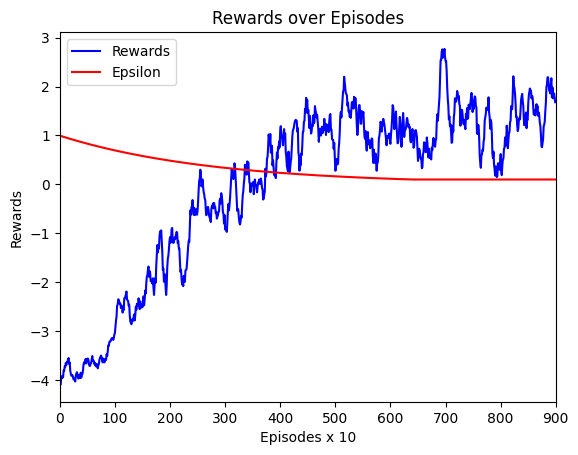

In [9]:
num_epochs = 9000

env = DQNBreakout(device=device, render_mode='rgb_array')

model = AtariNet(nb_actions=4).to(device)

model.load_the_model(run_num) #weights_filename='models\model_iter_5000.pt'

agent = Agent(model=model,
              device=device,
              epsilon=1.0,
              nb_warmup=5000,
              nb_actions=4,
              learning_rate=0.0007,
              memory_capacity=100000,
              batch_size=32)

with tqdm(total=num_epochs, desc="Training Progress") as pbar:
    agent.train(env=env, epochs=num_epochs, progress_bar=pbar)